## 協調フィルタリング (Collaborative Filtering)

映画のレーティングからレコメンドする映画をリストする

Source: http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-8/

アルゴリズムの流れ
1. 特徴xとパラメータθを小さなランダム値で初期化
2. J(x,θ)を最小化する
3. x(i)、θ(j)を使ってRatingを予想

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.io import loadmat
from scipy.optimize import minimize

In [2]:
# データを読み込む
# Y: 1〜5のレーティングがされた配列（映画数 x ユーザ数分だけある）
# R: ユーザが映画をレーティング済み(1)か否(0)かを保持（映画数 x ユーザ数分だけある）
data = loadmat('../data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

In [3]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

In [4]:
# 映画1のレーティングの平均
Y[1, R[1,:]].mean()

2.5832449628844114

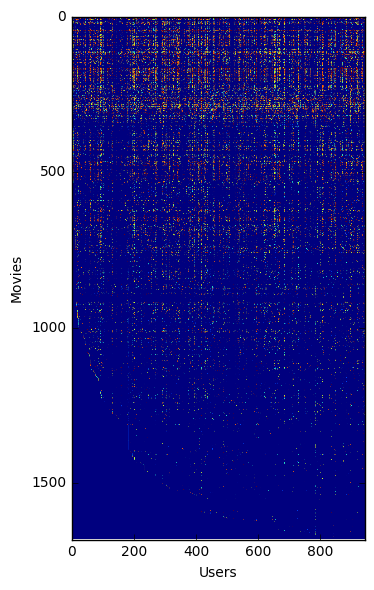

In [6]:
# データを表示
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

In [7]:
# 協調フィルタリングのコスト関数を定義
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y) # (1682, 943)
    R = np.matrix(R) # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    # パラメータの配列を行列に変換
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    # 初期化
    J = 0
    X_grad = np.zeros(X.shape) # (1682, 10)
    Theta_grad = np.zeros(Theta.shape) # (943, 10)
    # コストを計算
    error = np.multiply((X * Theta.T) - Y, R) # (1682, 943)
    squared_error = np.power(error, 2) # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    # 正規化を追加
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    # Gradientを計算
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    # X_gradとTheta_gradを１つの配列にする
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    return J, grad

In [10]:
def test_cost_function():
    """コスト関数をテストする"""
    users = 4
    movies = 5
    features = 3
    params_data = loadmat('../data/ex8_movieParams.mat')
    X = params_data['X']
    Theta = params_data['Theta']
    X_sub = X[:movies, :features]
    Theta_sub = Theta[:users, :features]
    Y_sub = Y[:movies, :users]
    R_sub = R[:movies, :users]
    params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))
    J, grad = cost(params, Y_sub, R_sub, features, 1.5)
    return J, grad

In [11]:
J, grad = test_cost_function()
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [13]:
# 映画名を取得
movie_idx = {}
f = open('../data/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [14]:
# レーティングを初期化
ratings = np.zeros((R.shape[0], 1))

# レーティングをサンプルでいれる
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

In [15]:
print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


In [16]:
# データセットにレーティングをいれる
R = data['R']
Y = data['Y']
Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

In [17]:
# トレーニングを実施
movies = Y.shape[0]
users = Y.shape[1]
features = 10
learning_rate = 10.

In [18]:
# Xとθをランダム値で初期化する
X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

In [20]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[1, :] == 1)[0]
    Ymean[i] = Y[i, idx].mean()
    Ynorm[i, idx] = Y[i, idx] - Ymean[i]

In [21]:
# 学習する（最適化）
fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate),
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 20704.03037555379
     jac: array([ -1.04228929e-01,   8.31657830e-02,   1.73006407e-02, ...,
         9.27605171e-05,   3.77662464e-05,   9.85849126e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 141
     nit: 100
    njev: 141
  status: 1
 success: False
       x: array([  3.36367303e-01,  -2.76043350e-01,   2.77757017e-01, ...,
         7.25496004e-06,   2.00629092e-06,   8.50598046e-06])

In [22]:
# we need to reshape our matrices back to their original dimensions.
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))
X.shape, Theta.shape

((1682, 10), (944, 10))

In [23]:
# Our trained parameters are now in X and Theta.
# We can use these to create some recommendations for the user we added earlier.
predictions = X * Theta.T
my_preds = predictions[:, -1] + Ymean
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[ 4.28244794],
        [ 4.16031511],
        [ 3.92367362],
        [ 3.87787299],
        [ 3.66412858],
        [ 3.65649343],
        [ 3.52671195],
        [ 3.47328991],
        [ 3.4656575 ],
        [ 3.35114682]])

In [24]:
# レコメンド
dx = np.argsort(my_preds, axis=0)[::-1]
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 3.068709854467935 for movie Toy Story (1995).
Predicted rating of 0.8855075441270711 for movie Copycat (1995).
Predicted rating of 1.0076393051947847 for movie Mighty Aphrodite (1995).
Predicted rating of 3.160310378762389 for movie Braveheart (1995).
Predicted rating of 0.21374356112664902 for movie Belle de jour (1967).
Predicted rating of 1.6564981556441103 for movie Clerks (1994).
Predicted rating of 1.0992420866446069 for movie I.Q. (1994).
Predicted rating of 3.083975696891158 for movie Shawshank Redemption, The (1994).
Predicted rating of 1.4045874679556698 for movie Mask, The (1994).
Predicted rating of 1.618331415392428 for movie Much Ado About Nothing (1993).
